In [1]:
"""
sets.ipynb

Jupyter Notebook to perform analysis on card sets.

Author: Jordan Bourdeau, Casey Forey
Date Created: 4/7/24
"""

'\nsets.ipynb\n\nJupyter Notebook to perform analysis on card sets.\n\nAuthor: Jordan Bourdeau, Casey Forey\nDate Created: 4/7/24\n'

In [13]:
# Imports
import json
from matplotlib import pyplot as plt
import numpy as np
import os
import pandas as pd

from src import constants as c
from src.load import load_card_data as lcd
from src.load import load_price_data as lpd
from src.load import load_set_data as lsd
from src.load import load_tournament_data as ltd
from src.load import load_utils
from src.plot import plot_set_data as psd

In [3]:
# Load dataset
all_printings_filepath: str = os.path.join(c.DATA_DIRECTORY, 'AllPrintings.json')
all_printings: dict = load_utils.load_json_data(all_printings_filepath)

In [4]:
lsd.save_format_set_ban_counts(all_printings, 'modern')

In [5]:
df = lcd.load_first_card_printing_in_format('modern', all_printings)
df.head()

,card_name,set_name,set_code,release_year,release_month
0,Thundering Mightmare,NaN,NaN,NaN,NaN
1,Temur Banner,Khans of Tarkir,KTK,2014.0,9.0
2,Halo Hunter,Zendikar,ZEN,2009.0,10.0
3,Scarecrow Guide,Wilds of Eldraine,WOE,2023.0,9.0
4,Frillscare Mentor,Ikoria: Lair of Behemoths,IKO,2020.0,4.0


In [6]:
# Augmenting set data with tournament data and number of banend cards
set_card_usages_and_bans: pd.DataFrame = lsd.load_augmented_set_data(all_printings, 'modern')

In [7]:
set_card_usages_and_bans.head()

,set_code,total_count,set_name,num_banned,release_year,release_month,set_size
0,10E,148,Tenth Edition,0,2007,7,383
1,5DN,9403,Fifth Dawn,1,2004,6,165
2,8ED,13761,Eighth Edition,0,2003,7,350
3,9ED,338,Ninth Edition,4,2005,7,350
4,AER,9263,Aether Revolt,0,2017,1,184


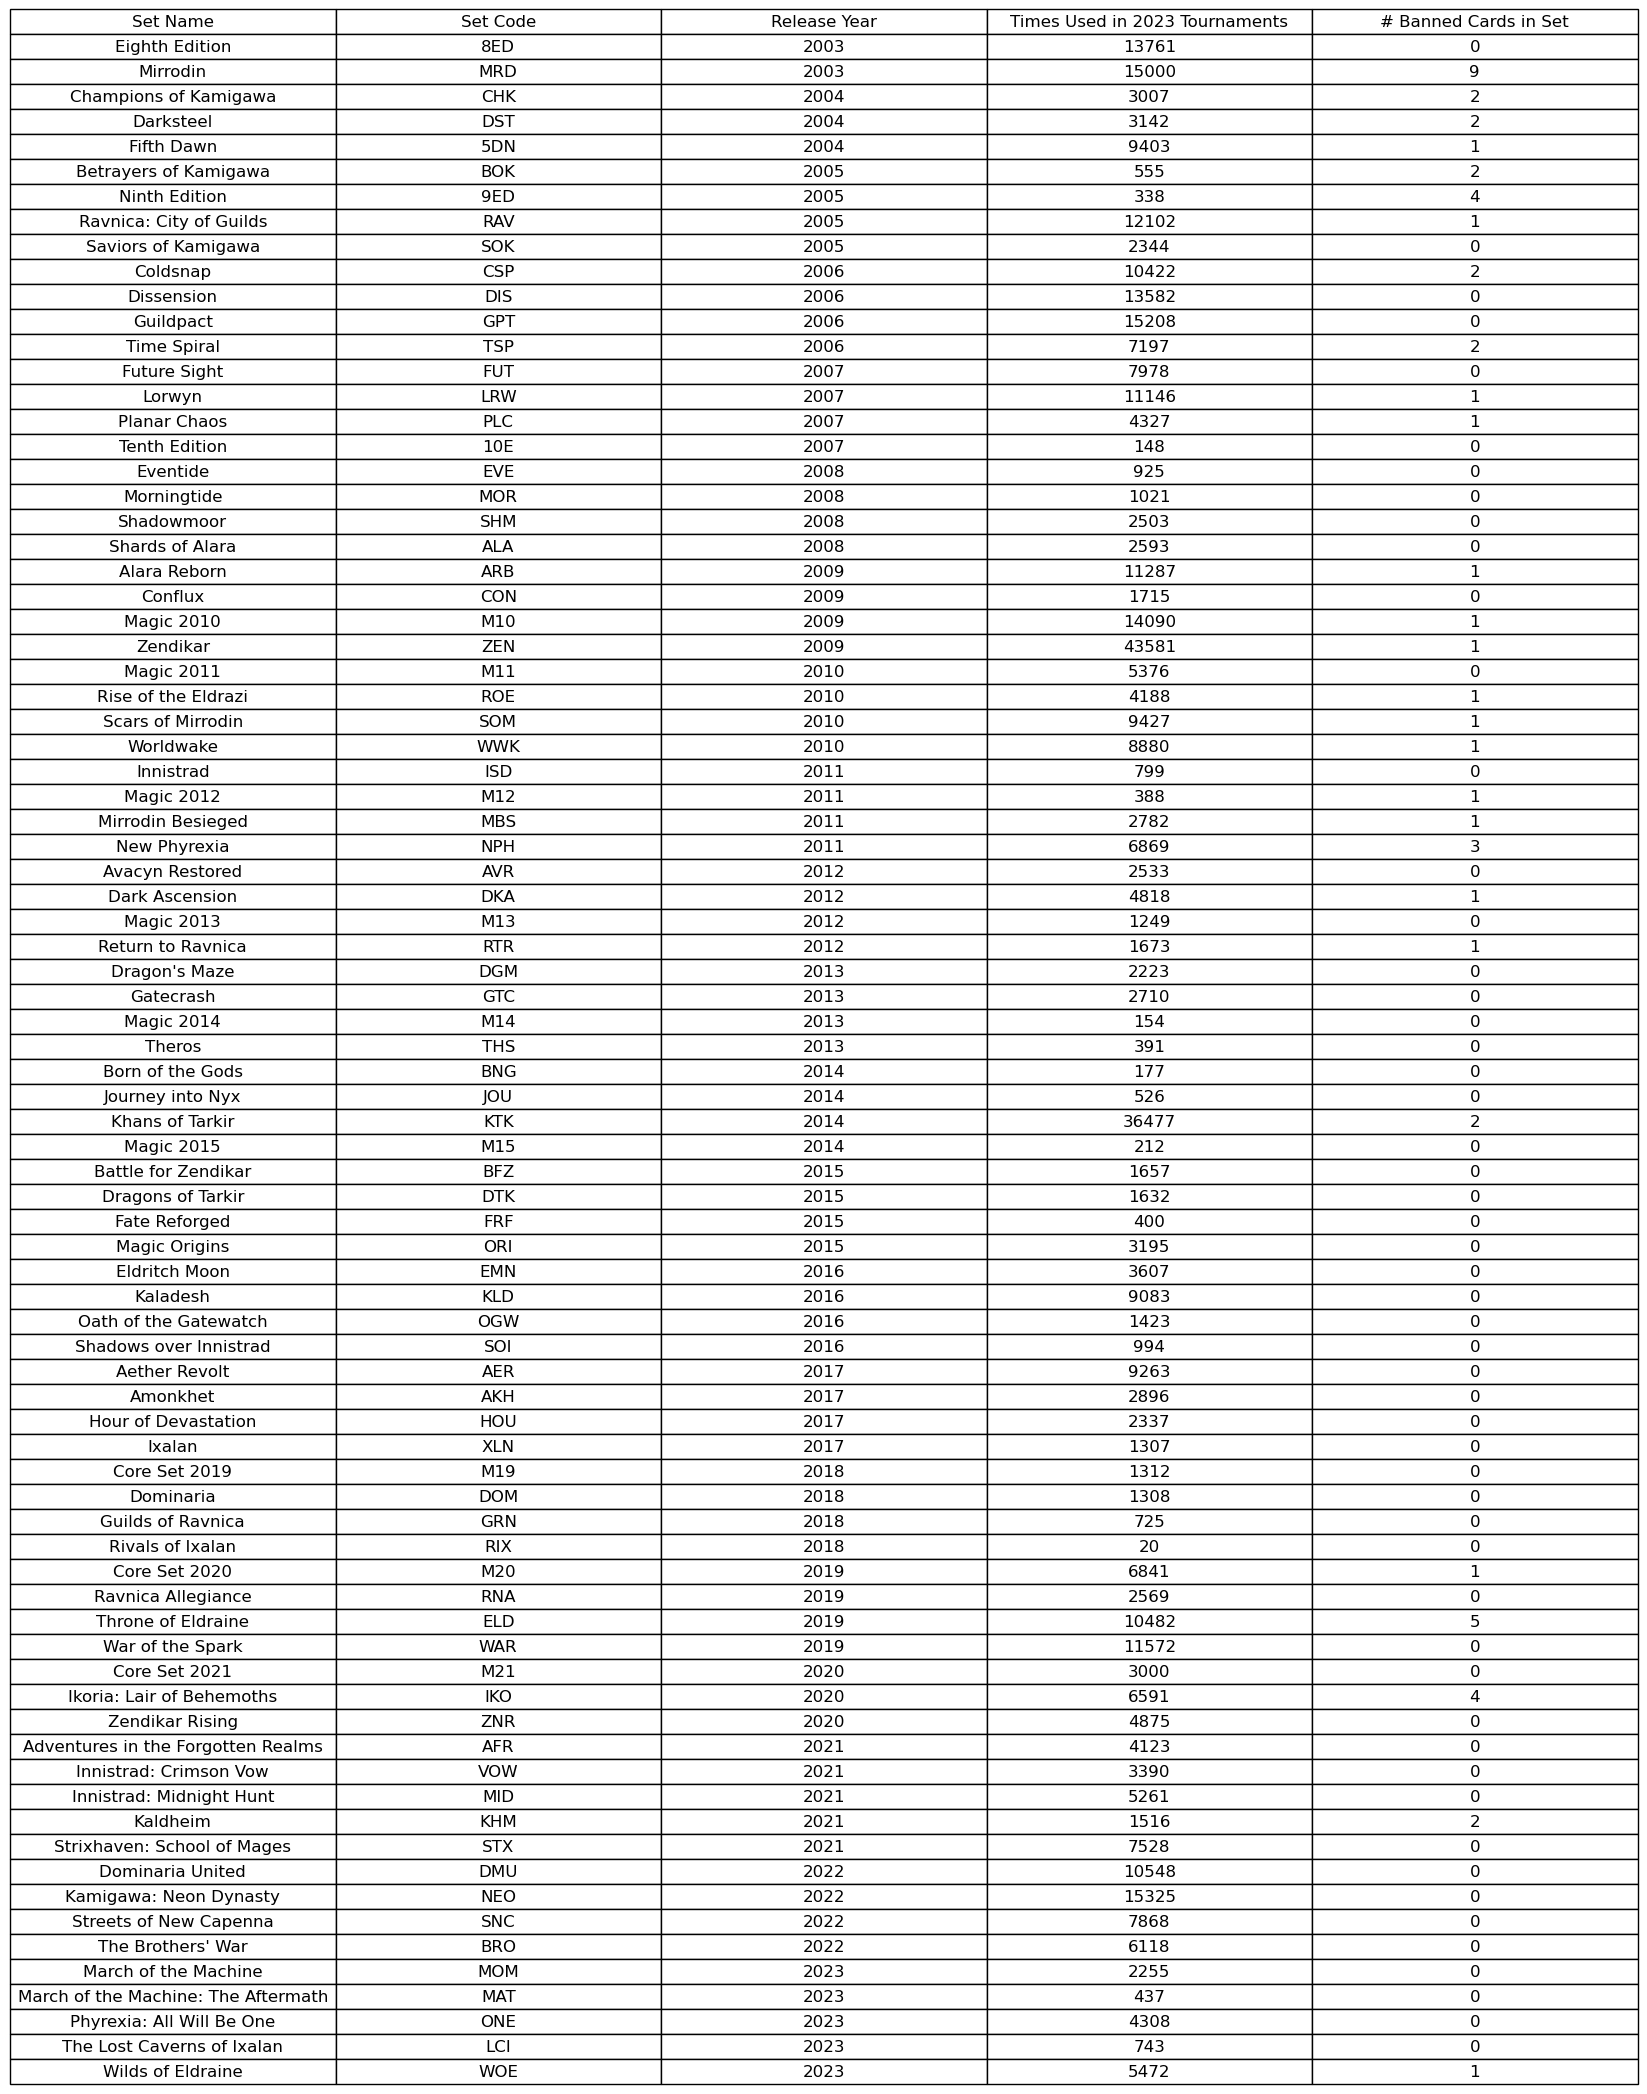

In [15]:
psd.plot_set_table(set_card_usages_and_bans)